<a href="https://colab.research.google.com/github/seyed-mohammadreza-mousavi/wwa/blob/main/7_omit_oversampled_with_cpso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score, precision_score, precision_recall_curve, auc, roc_auc_score
from sklearn.datasets import make_gaussian_quantiles
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVC
import seaborn as sns
import random
from sklearn.metrics import classification_report, roc_auc_score

# Define the fitness function
#def fitness_function(sample, majority_samples):
    # Calculate the fitness based on proximity to majority samples or other criteria
#    fitness = np.mean(np.linalg.norm(sample - majority_samples, axis=1))
#    return fitness
def calculate_noise_fitness(sample, majority_samples, k=5, noise_threshold=0.2):
    # Convert the scalar sample to a 1D array
    sample = np.array([sample])

    # Add a synthetic second feature with a constant value of 0
    sample = np.column_stack((sample, np.zeros(sample.shape[0])))

    # Fit a KNN model on the majority samples
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(majority_samples)

    # Find the distances and indices of the k nearest neighbors
    distances, indices = knn.kneighbors(sample)

    # Calculate the noise ratio based on the distances to nearest neighbors
    noise_samples = np.sum(distances > noise_threshold)
    noise_ratio = noise_samples / k
    noise_fitness = 1 - noise_ratio

    return noise_fitness

def fitness_function(sample, majority_samples):
    # Calculate the fitness based on proximity to majority samples and noise detection
    proximity_fitness = np.mean(np.linalg.norm(sample - majority_samples, axis=1))
    noise_fitness = calculate_noise_fitness(sample, majority_samples)

    # Combine proximity and noise fitness using a weighted sum
    weight_proximity = 0.8  # Adjust the weight for proximity fitness
    weight_noise = 0.2  # Adjust the weight for noise fitness

    fitness = weight_proximity * proximity_fitness + weight_noise * noise_fitness
    return fitness

# Define the PSO algorithm with chaotic parameter adaptation
def chaotic_pso(fitness_func, num_particles, num_iterations, majority_samples):
    # Define the chaotic map function
    def chaotic_map(x, a):
        return np.clip(4 * a * x * (1 - x), -1e100, 1e100)  # Apply clipping to limit values

    # Initialize particles' positions and velocities
    positions = np.random.uniform(low=-10, high=10, size=(num_particles,))
    velocities = np.random.uniform(low=-1, high=1, size=(num_particles,))

    # Initialize global best position and corresponding value
    global_best_pos = positions[0]
    global_best_val = fitness_func(global_best_pos, majority_samples)

    # Initialize lists to store best positions and values at each iteration
    best_positions = [global_best_pos]
    best_values = [global_best_val]

    # PSO main loop
    for j in range(num_iterations):
        a = np.random.uniform(low=2.9, high=4.0)  # Chaotic map parameter

        for i in range(num_particles):
            # Update particle's velocity using chaotic map
            velocities[i] = velocities[i] + 2 * chaotic_map(best_positions[-1] - positions[i], a) \
                            + 2 * chaotic_map(global_best_pos - positions[i], a)

            # Update particle's position
            positions[i] = positions[i] + velocities[i]

            # Update global best position and value
            particle_fitness = fitness_func(positions[i], majority_samples)
            if particle_fitness < global_best_val:
                global_best_pos = positions[i]
                global_best_val = particle_fitness

        # Print the best positions and values for the current iteration
        if j%10==0:
          print(f"Iteration {j + 1} - Best Positions: {best_positions}")
          print(f"Iteration {j + 1} - Best Values: {best_values}")

        # Store best position and value at each iteration
        best_positions.append(global_best_pos)
        best_values.append(global_best_val)

    return best_positions, best_values

# Generate a binary dataset
#X, y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=42)
#X, y = make_blobs(n_samples=10000, n_features=2, centers=[(-2, -2), (2, 2)], cluster_std=0.5, random_state=42)
#X, y = make_blobs(n_samples=10000, n_features=2, centers=[(-2, -2), (2, 2)], cluster_std=[1.5, 1.5], random_state=42)

In [24]:
# Set the parameters for the imbalanced dataset
n_samples = 10000
n_features = 2
weights = [0.99, 0.01]  # Adjust the class weights here
class_sep = 2.0

# Set the mean and covariance for the minority class
mu_minority = np.array([-1, -1])  # Mean of the minority class
cov_minority = np.array([[1, 0], [0, 1]])  # Covariance matrix of the minority class

# Set the mean and covariance for the majority class
mu_majority = np.array([-1, -1])  # Mean of the majority class
cov_majority = np.array([[1, 0], [0, 1]])  # Covariance matrix of the majority class

# Generate samples for the minority class
minority_samples = int(n_samples * weights[1])
X_minority = np.random.multivariate_normal(mu_minority, cov_minority, minority_samples)
y_minority = np.ones(minority_samples, dtype=int)

# Generate samples for the majority class
majority_samples = n_samples - minority_samples
X_majority = np.random.multivariate_normal(mu_majority, cov_majority, majority_samples)
y_majority = np.zeros(majority_samples, dtype=int)

# Concatenate the minority and majority class samples
X = np.concatenate((X_majority, X_minority))
y = np.concatenate((y_majority, y_minority))

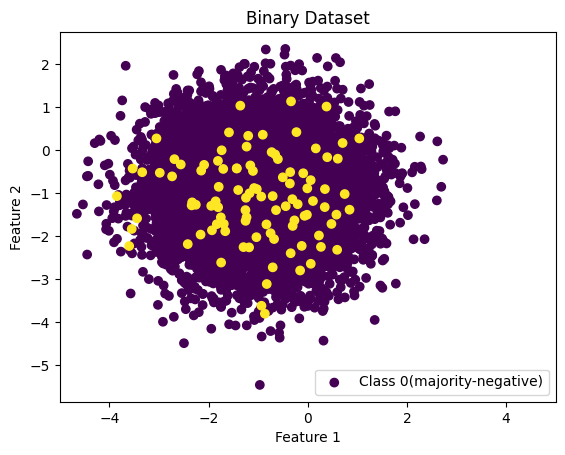

In [25]:
# Separate features
feature_1 = X[:, 0]
feature_2 = X[:, 1]
feature_1.shape, feature_2.shape

# Visualize the dataset
plt.scatter(feature_1, feature_2, c=y)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Binary Dataset')

# Add legend labels
plt.legend(['Class 0(majority-negative)', 'Class 1'])
plt.xlim([-5, 5])

plt.show()

In [26]:
# Oversample the minority class using a chaotic map
chaotic_map = lambda x: 3.9 * x * (1 - x)
n_oversample = majority_samples - minority_samples

np.random.seed(42)  # Set a seed for reproducibility
x0 = np.random.rand()
x = x0
oversampled_X_minority = np.zeros((n_oversample, n_features))
for i in range(n_oversample):
    x = chaotic_map(x)
    oversampled_X_minority[i] = mu_minority + x * (cov_minority @ np.random.randn(n_features))

# Concatenate the minority and majority class samples
X = np.concatenate((X_majority, X_minority, oversampled_X_minority))
y = np.concatenate((y_majority, y_minority, np.ones(n_oversample, dtype=int)))

X.shape, y.shape, len(X_minority), len(X_majority)

((19800, 2), (19800,), 100, 9900)

In [27]:
# Call the chaotic PSO algorithm with the fitness function and oversampled minority samples
num_particles = 200
num_iterations = 500

best_positions, best_values = chaotic_pso(fitness_function, num_particles, num_iterations, oversampled_X_minority)

Iteration 1 - Best Positions: [9.036770939333202]
Iteration 1 - Best Values: [11.371154511956163]
Iteration 11 - Best Positions: [9.036770939333202, -1.7574668073641533, -1.7574668073641533, -1.7574668073641533, -1.7574668073641533, -1.7574668073641533, -1.7574668073641533, -1.7574668073641533, -1.7574668073641533, -1.7574668073641533, -1.7574668073641533]
Iteration 11 - Best Values: [11.371154511956163, 1.2392349134152503, 1.2392349134152503, 1.2392349134152503, 1.2392349134152503, 1.2392349134152503, 1.2392349134152503, 1.2392349134152503, 1.2392349134152503, 1.2392349134152503, 1.2392349134152503]
Iteration 21 - Best Positions: [9.036770939333202, -1.7574668073641533, -1.7574668073641533, -1.7574668073641533, -1.7574668073641533, -1.7574668073641533, -1.7574668073641533, -1.7574668073641533, -1.7574668073641533, -1.7574668073641533, -1.7574668073641533, -1.7574668073641533, -1.7574668073641533, -1.7574668073641533, -1.7574668073641533, -1.7574668073641533, -1.7574668073641533, -1.75

In [28]:
# Analyze the results
noise_samples = []
threshold = np.percentile(best_values, 75)  # Adjust the threshold based on your needs
for i, val in enumerate(best_values):
    if val > threshold:
        noise_samples.append(best_positions[i])

# Print the identified noise samples
print("Identified Noise Samples:")
for sample in noise_samples:
    print(sample)

Identified Noise Samples:
9.036770939333202


In [29]:
# Find indices where the value is equal to 9.036770939333202
indices = np.where(oversampled_X_minority == noise_samples)[0]

# Remove the corresponding indices from the array
filtered_oversampled_X_minority = np.delete(oversampled_X_minority, indices, axis=0)

# Concatenate the minority and majority class samples
X = np.concatenate((X_majority, X_minority, filtered_oversampled_X_minority))
y = np.concatenate((y_majority, y_minority, np.ones(n_oversample, dtype=int)))

X.shape, y.shape, len(X_minority), len(X_majority)

((19800, 2), (19800,), 100, 9900)

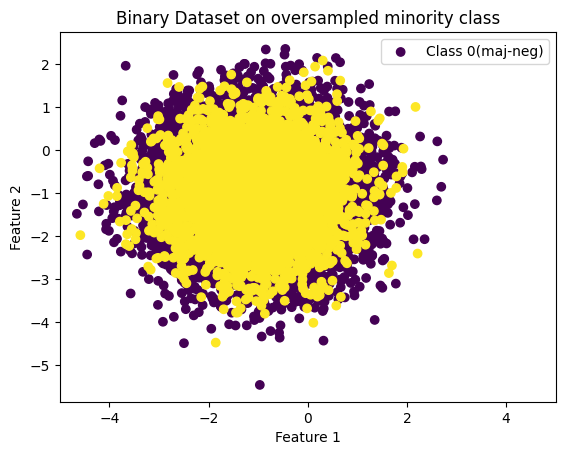

In [30]:
# Separate features
feature_1 = X[:, 0]
feature_2 = X[:, 1]
feature_1.shape, feature_2.shape

# Visualize the dataset
plt.scatter(feature_1, feature_2, c=y)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Binary Dataset on oversampled minority class')
# Add legend labels
plt.legend(['Class 0(maj-neg)', 'Class 1(min-pos)'])
plt.xlim([-5, 5])

plt.show()

In [31]:
# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set the number of epochs
max_epochs = 2000
stopper=500

# Initialize the classifier
#classifier = SVC()
#classifier = SGDClassifier(loss='hinge')
classifier = LogisticRegression()

# Initialize variables to track the best F-measure and corresponding epoch
best_f_measure = 0
best_epoch = 0

for epoch in range(1, max_epochs + 1):
    # Shuffle the training data
    #random.shuffle(X_train)
    #random.shuffle(y_train)

    # Train the classifier
    classifier.fit(X_train, y_train)
    #classifier.partial_fit(X_train, y_train, classes=np.unique(y_train))

    # Make predictions on the test set
    y_pred = classifier.predict(X_test)

    # Calculate F-measure
    f_measure = f1_score(y_test, y_pred)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Print the results for the current epoch
    print(f"Epoch {epoch}:")
    print("F-measure:", f_measure)
    print("Confusion Matrix:")
    print(cm)
    print("Accuracy:", accuracy)
    print()

    # Check if the current F-measure is the best so far
    if f_measure > best_f_measure:
        best_f_measure = f_measure
        best_epoch = epoch

    # Check if the F-measure has not improved for a certain number of epochs
    if epoch - best_epoch >= stopper:
        print(f"F-measure has not improved for {stopper} epochs. Stopping training.")
        break

# Train a classifier (Support Vector Machine in this example)
#classifier = SVC()
#classifier.fit(X_train, y_train)

# Make predictions on the test set
#y_pred = classifier.predict(X_test)

Epoch 1:
F-measure: 0.6478365384615385
Confusion Matrix:
[[ 585 1420]
 [ 338 1617]]
Accuracy: 0.556060606060606

Epoch 2:
F-measure: 0.6478365384615385
Confusion Matrix:
[[ 585 1420]
 [ 338 1617]]
Accuracy: 0.556060606060606

Epoch 3:
F-measure: 0.6478365384615385
Confusion Matrix:
[[ 585 1420]
 [ 338 1617]]
Accuracy: 0.556060606060606

Epoch 4:
F-measure: 0.6478365384615385
Confusion Matrix:
[[ 585 1420]
 [ 338 1617]]
Accuracy: 0.556060606060606

Epoch 5:
F-measure: 0.6478365384615385
Confusion Matrix:
[[ 585 1420]
 [ 338 1617]]
Accuracy: 0.556060606060606

Epoch 6:
F-measure: 0.6478365384615385
Confusion Matrix:
[[ 585 1420]
 [ 338 1617]]
Accuracy: 0.556060606060606

Epoch 7:
F-measure: 0.6478365384615385
Confusion Matrix:
[[ 585 1420]
 [ 338 1617]]
Accuracy: 0.556060606060606

Epoch 8:
F-measure: 0.6478365384615385
Confusion Matrix:
[[ 585 1420]
 [ 338 1617]]
Accuracy: 0.556060606060606

Epoch 9:
F-measure: 0.6478365384615385
Confusion Matrix:
[[ 585 1420]
 [ 338 1617]]
Accuracy: 0.

F1 Score(combination and prec and recall(se)): 0.6478365384615385 (64.78%)
accuracy(correct pred/total pred): 0.556060606060606 (55.61%)
sensitivity: (tp rate, how well is pos class predicted): 0.8271099744245525 (82.71%)
specificity: (tn rate, how well is neg class predicted): 0.29177057356608477 (29.18%)
precision: (fraction of samples assigned to pos class, that belong to pos class): 0.5324333223575898 (53.24%)
pr_auc: (used for evaluation of a classifier focused on pos(min) samples): 0.7224484160678388 (72.24%)
Confusion Matrix:
[[ 585 1420]
 [ 338 1617]]
True Positive (TP): 1617 (40.83%)
True Negative (TN): 585 (14.77%)
False Positive (FP): 1420 (35.86%)
False Negative (FN): 338 (8.54%)


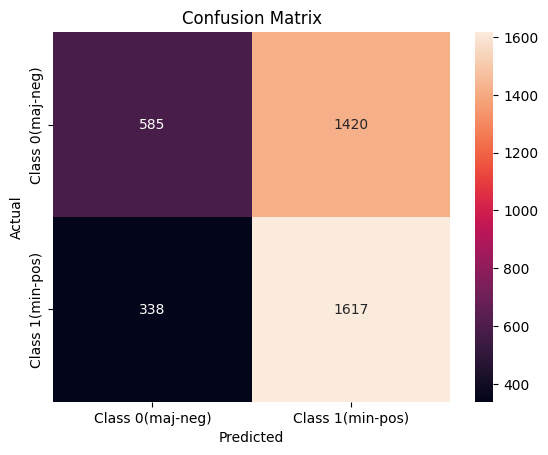

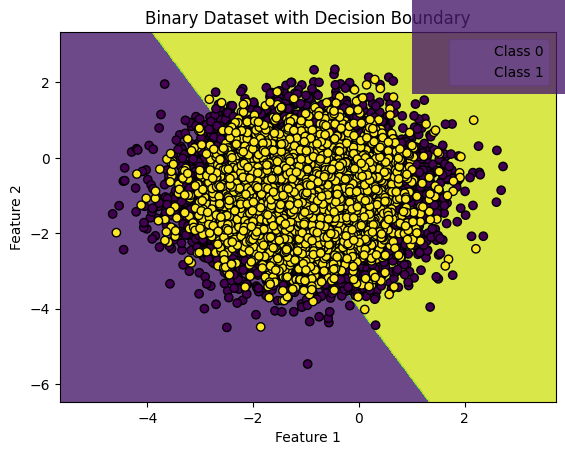

In [32]:
# Calculate the total number of instances
total_instances = len(y_test)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
f1_percentage = f1*100
accuracy = accuracy_score(y_test, y_pred)
accuracy_percentage = accuracy*100
sensitivity = recall_score(y_test, y_pred)
sensitivity_percentage = sensitivity * 100
precision = precision_score(y_test, y_pred)
precision_percentage=precision*100

precision_r, recall_r, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall_r, precision_r)
pr_auc_percentage = pr_auc * 100

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

specificity = tn / (tn + fp)
specificity_percentage = specificity * 100

print("F1 Score(combination and prec and recall(se)):", f1, "({:.2f}%)".format(f1_percentage))
print("accuracy(correct pred/total pred):", accuracy, "({:.2f}%)".format(accuracy_percentage))
print("sensitivity: (tp rate, how well is pos class predicted):", sensitivity, "({:.2f}%)".format(sensitivity_percentage))
print("specificity: (tn rate, how well is neg class predicted):", specificity, "({:.2f}%)".format(specificity_percentage))
print("precision: (fraction of samples assigned to pos class, that belong to pos class):", precision, "({:.2f}%)".format(precision_percentage))
print("pr_auc: (used for evaluation of a classifier focused on pos(min) samples):", pr_auc, "({:.2f}%)".format(pr_auc_percentage))

# Calculate the percentages
tp_percentage = tp / total_instances * 100
tn_percentage = tn / total_instances * 100
fp_percentage = fp / total_instances * 100
fn_percentage = fn / total_instances * 100

print("Confusion Matrix:")
print(cm)
print("True Positive (TP):", tp, "({:.2f}%)".format(tp_percentage))
print("True Negative (TN):", tn, "({:.2f}%)".format(tn_percentage))
print("False Positive (FP):", fp, "({:.2f}%)".format(fp_percentage))
print("False Negative (FN):", fn, "({:.2f}%)".format(fn_percentage))

# Visualize the confusion matrix
labels = ['Class 0(maj-neg)', 'Class 1(min-pos)']
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Visualize the decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(feature_1, feature_2, c=y, edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Binary Dataset with Decision Boundary')
plt.legend(['Class 0', 'Class 1'])
plt.show()

In [ ]:
'''
Are you predicting probabilities?
  Do you need class labels?
    Is the positive class more important?
      Use Precision-Recall AUC
    Are both classes important?
      Use ROC AUC
  Do you need probabilities?
    Use Brier Score and Brier Skill Score
Are you predicting class labels?
  Is the positive class more important?
    Are False Negatives and False Positives Equally Important?
      Use F1-Measure
    Are False Negatives More Important?
      Use F2-Measure
    Are False Positives More Important?
      Use F0.5-Measure
  Are both classes important?
    Do you have < 80%-90% Examples for the Majority Class?
      Use Accuracy
    Do you have > 80%-90% Examples for the Majority Class?
      Use G-Mean
'''